**J. Behler and M. Parrinello, Generalized Neural-Network Representation of High-Dimensional Potential-Energy Surfaces, PRL 98, 146401 (2007)**

In [1]:
from math import exp, pow, sqrt, tanh, pi, cos, ceil
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
import numpy as np
np.set_printoptions(threshold=np.inf)
import random

from pytorch_lightning import loggers as pl_loggers
#from sklearn.model_selection import train_test_split
torch.set_printoptions(threshold=np.inf)


![TOC.jpg](./TOC.jpg)

In [2]:
#Require: Num_atom, Num_config, Num_layer, and Num_node
Num_atom = 14  # QM area
Num_atom_all = 6041 # QM and MM area
Num_config = 1000 #Number of snapshots
#Num_feature = 3

Num_train = int(Num_config * 0.6) # Number of training set
Num_valid = int(Num_config * 0.2) # Number of valid set
Num_test = Num_config -  Num_train - Num_valid #Number of test set

element_list = ['C', 'C', 'H', 'H', 'H', 'C', 'H', 'H', 'O', 'C', 'C', 'H', 'H', 'H']
unique_element_list = np.unique(element_list)
Num_element = unique_element_list.size

element_index_in_molecule = []
for i_element in range(Num_element):
    new_list = [i for i in range(np.array(element_list).size) if element_list[i] == unique_element_list[i_element]]
    element_index_in_molecule.append(new_list)
    
type_list = []
for i_type in range(np.array(element_list).size):
    j, = np.where(unique_element_list == element_list[i_type])
    type_list.append(j[0])
    
C_atom = element_index_in_molecule[0] #index of C
O_atom = element_index_in_molecule[1]
H_atom = element_index_in_molecule[2]

symmetric_hparam1=[ [0.4, 0.0, 0.2, 6.0],
                   [0.1, 0.0, 0.8, 6.0],
                   [0.4, 0.0, 0.4, 6.0] ]   #geta, g1rs, g2zeta, rc
symmetric_hparam2=[ [0.6, 0.0, 0.3, 6.0],
                   [0.2, 0.0, 1.2, 6.0],
                   [0.6, 0.0, 0.6, 6.0] ]   #geta, g1rs, g2zeta, rc
symmetric_hparam3=[ [0.8, 0.0, 0.4, 6.0],
                   [0.2, 0.0, 1.6, 6.0],
                   [0.8, 0.0, 0.8, 6.0] ]   #geta, g1rs, g2zeta, rc



def unitconversion(list,wcba=(1/0.52917724)**2):
    result = [  [i*wcba  for i in j] for j in list] # bohr to A
    return result

symmetric_hparam=[unitconversion(symmetric_hparam1),unitconversion(symmetric_hparam2)
                 ,unitconversion(symmetric_hparam3),'stationary']
Num_feature = 2*(len(symmetric_hparam)-1)+1


charge_of_water = [-0.834, 0.417, 0.417] # 0 and H

In [3]:
#generate random lists for training, validation and test sets

random_list = np.arange(1, Num_config + 1)
np.random.shuffle(random_list)
train_list = random_list[ : Num_train].copy()
valid_list = random_list[Num_train : Num_train + Num_valid].copy()
test_list = random_list[Num_train + Num_valid : Num_train + Num_valid+Num_test].copy()

#print(train_list,test_list,valid_list)

In [4]:
#read coordinate and energy of each snapshot
#filename_E='deltaE.def'
filename_E = 'Energy.dat'
path_xyz='./xyz/'

def readCxyz(choselist, path, n):
    '''Read Cartesian coordinates according to randomlist, for certain path, with fixed filename format'''

    C = np.zeros((len(choselist), n, 3))
    for i in range( len(choselist) ):
        j = choselist[i]
        filename = path + str(j) + '.xyz'
        fc = open(filename)
#        line = fc.readline()
#        line = fc.readline()
        for k in range(Num_atom_all):
            line = fc.readline()
            if not line:
               break
            _, coord_x, coord_y, coord_z = line.strip().split()
            C[i][k][0] = float(coord_x)
            C[i][k][1] = float(coord_y)
            C[i][k][2] = float(coord_z)
        fc.close()
    return C


def readE(choselist, filename):

    ''' Read E according to randomlist '''

    E = []
    Echose = []

    e1 = open(filename,'r')
    while True:
        line = e1.readline()
        if not line:
           break
        tem = line.strip().split()[1]
        E.append(float(tem))
    
    Echose = np.zeros(len(choselist))
    for i in range( len(choselist) ):
        j = choselist[i]-1 #python from 0
        Echose[i] = E[j]
    e1.close()
    return Echose


train_E = readE(train_list, filename_E)
valid_E = readE(valid_list, filename_E)
test_E  = readE(test_list, filename_E)

train_coord = readCxyz(train_list, path_xyz, Num_atom_all)
valid_coord = readCxyz(valid_list, path_xyz, Num_atom_all)
test_coord  = readCxyz(test_list, path_xyz, Num_atom_all)

In [5]:
#Package parameters to class
class nn_param (object):
    def __init__(self):
        self.geta = None
        self.g1rs = None
        self.g2zeta = None
        self.ctrc = None
        self.Num_atom = None
        self.Num_atom_all = None
        self.Num_conf = None
        self.lenhparam = None

    def configuration(self, Num_atom, Num_atom_all, Num_conf, type_list, symmetric_hparam):
        '''specify'''
        self.Num_atom = Num_atom
        self.Num_atom_all = Num_atom_all
        self.Num_conf = Num_conf
        
        
        if symmetric_hparam[-1] =='fixed' or 'stationary':
            self.lenhparam=len(symmetric_hparam)-1

            self.geta   = np.zeros((self.Num_atom,self.lenhparam))
            self.g1rs  = np.zeros((self.Num_atom,self.lenhparam))
            self.g2zeta   = np.zeros((self.Num_atom,self.lenhparam))
            self.ctrc  = np.zeros((self.Num_atom,self.lenhparam))
        if self.lenhparam==1:
                for i in range(self.Num_atom):
                    self.geta[i,0]  = symmetric_hparam[type_list[i]][0]
                    self.g1rs[i,0] = symmetric_hparam[type_list[i]][1]
                    self.g2zeta[i,0]  = symmetric_hparam[type_list[i]][2]
                    self.ctrc[i,0] = symmetric_hparam[type_list[i]][3]
        else:
                for i in range(self.Num_atom):
                    for j in range(self.lenhparam):
                        self.geta[i,j]  = symmetric_hparam[j][type_list[i]][0]
                        self.g1rs[i,j] = symmetric_hparam[j][type_list[i]][1]
                        self.g2zeta[i,j]  = symmetric_hparam[j][type_list[i]][2]
                        self.ctrc[i,j] = symmetric_hparam[j][type_list[i]][3]
        

p_train = nn_param() #all the input parameters in a class
p_valid = nn_param()
p_test  = nn_param()

p_train.configuration(Num_atom, Num_atom_all, Num_train, type_list, symmetric_hparam)
p_valid.configuration(Num_atom, Num_atom_all, Num_valid, type_list, symmetric_hparam)
p_test.configuration(Num_atom, Num_atom_all, Num_test, type_list, symmetric_hparam)


In [6]:
class molecule(object):
    def __init__(self, nn_param):
        Num_atom = nn_param.Num_atom
        Len_hparam =nn_param.lenhparam
        
        self.g1 = np.zeros((Num_atom,Len_hparam))
        self.g2 = np.zeros((Num_atom,Len_hparam))
        self.gv = np.zeros((Num_atom,1))
        #self.lenhparam
    
    def distance(self, r1, r2):

        return sqrt((r1[0]-r2[0])**2 + (r1[1]-r2[1])**2 + (r1[2]-r2[2])**2)

    def cosijk(self, d1, d2, d3):

        return (d1**2 + d3**2 - d2**2)/(2 * d1 * d3)
        
    def calc_feature(self, coord, nn_param, charge_of_water):
        Len_hparam =nn_param.lenhparam
        Num_atom = nn_param.Num_atom
        Num_atom_all = nn_param.Num_atom_all
        dist = np.zeros([Num_atom, Num_atom_all])
        fc = np.zeros([Num_atom, Num_atom,Len_hparam])
        fc_tanh= np.zeros([Num_atom, Num_atom,Len_hparam])
        geta = nn_param.geta
        g1rs = nn_param.g1rs
        g2zeta = nn_param.g2zeta
        rc = nn_param.ctrc
        
        #dist
        for i_atom in range(Num_atom):
            for j_atom in range(Num_atom_all):
                if j_atom == i_atom:
                    pass
                else:
                    dist[i_atom, j_atom] = self.distance(coord[i_atom, :], coord[j_atom, :])
        #function c        
        for n_lenhparam in range(Len_hparam):
            for i_atom in range(Num_atom):
                for j_atom in range(i_atom+1, Num_atom):
                    dist_ij = dist[i_atom, j_atom]
                    if dist_ij <= rc[i_atom,n_lenhparam]:
                        fc[i_atom, j_atom,n_lenhparam] =  0.5 * ( cos( pi * dist_ij / rc[i_atom,n_lenhparam] ) + 1 )
                        fc_tanh[i_atom, j_atom,n_lenhparam]=tanh(1-(dist_ij / rc[i_atom,n_lenhparam])) **3
                    else:
                        fc[i_atom, j_atom,n_lenhparam] =  0.0
                    fc[j_atom, i_atom,n_lenhparam] = fc[i_atom, j_atom,n_lenhparam]
                    fc_tanh[j_atom, i_atom,n_lenhparam] = fc_tanh[i_atom, j_atom,n_lenhparam]
        
        #cal g1
        for n_lenhparam in range(Len_hparam):
            for i_atom in range(Num_atom):
                for j_atom in range(Num_atom):
                    if j_atom == i_atom:
                        pass
                    else:
                        self.g1[i_atom,n_lenhparam] += exp( -geta[i_atom,n_lenhparam] * \
                        ( (dist[i_atom, j_atom] - g1rs[i_atom,n_lenhparam])**2 ) )* fc[j_atom, i_atom,n_lenhparam]
                        
         #cal g2
        for n_lenhparam in range(Len_hparam):
            for i_atom in range(Num_atom):
                for j_atom in range(Num_atom):
                    if j_atom == i_atom:
                        pass
                    else:
                        for k_atom in range(Num_atom):
                            if k_atom  == j_atom :
                                pass
                            elif k_atom == i_atom:
                                pass
                            else:
                                self.g2[i_atom,n_lenhparam] += 2**(1-g2zeta[i_atom,n_lenhparam])*( ( 1 + self.cosijk( dist[j_atom, k_atom], dist[i_atom, k_atom], dist[i_atom, j_atom] ) )\
                                **(g2zeta[i_atom,n_lenhparam])) *exp( -geta[i_atom,n_lenhparam] * ( dist[i_atom, j_atom]**2 + dist[i_atom, k_atom]**2 + dist[i_atom, k_atom]**2) ) \
                                *fc[j_atom, i_atom,n_lenhparam] * fc[k_atom, i_atom,n_lenhparam] * fc[j_atom, k_atom,n_lenhparam]
            
        #cal gv
        for i_atom in range(Num_atom):
            for j_atom in range(Num_atom, Num_atom_all):
                if (j_atom - Num_atom) % 3 == 0:
                    self.gv[i_atom,0] += charge_of_water[0]/(dist[i_atom, j_atom]**2)
                else:
                    self.gv[i_atom,0] += charge_of_water[1]/(dist[i_atom, j_atom]**2)

In [7]:
train_snapshots = [molecule(p_train) for i_conf in range(Num_train)]
valid_snapshots = [molecule(p_valid) for i_conf in range(Num_valid)]
test_snapshots = [molecule(p_test) for i_conf in range(Num_test)]

for i_conf in range(Num_train):
    train_snapshots[i_conf].calc_feature(train_coord[i_conf,:,:], p_train, charge_of_water)
    
for i_conf in range(Num_valid):
    valid_snapshots[i_conf].calc_feature(valid_coord[i_conf,:,:], p_valid, charge_of_water)
    
for i_conf in range(Num_test):
    test_snapshots[i_conf].calc_feature(test_coord[i_conf,:,:], p_test, charge_of_water)

In [8]:
Num_feature = 2*(len(symmetric_hparam)-1)+1
input_feature_train = np.empty(shape=[0, Num_atom * Num_feature])
input_feature_valid = np.empty(shape=[0, Num_atom * Num_feature])
input_feature_test  = np.empty(shape=[0, Num_atom * Num_feature])


for i_conf in range(Num_train):
    input_feature_train = np.append(input_feature_train, [np.concatenate((train_snapshots[i_conf].g1.ravel(), train_snapshots[i_conf].g2.ravel(), train_snapshots[i_conf].gv.ravel()))], axis = 0)
    #input_feature_train = np.append(input_feature_train, [np.concatenate((train_snapshots[i_conf].g1, train_snapshots[i_conf].g2, train_snapshots[i_conf].gv))], axis = 0)
    
for i_conf in range(Num_valid):
    input_feature_valid = np.append(input_feature_valid, [np.concatenate((valid_snapshots[i_conf].g1.ravel(), valid_snapshots[i_conf].g2.ravel(), valid_snapshots[i_conf].gv.ravel()))], axis = 0)
    #input_feature_valid = np.append(input_feature_valid, [np.concatenate((valid_snapshots[i_conf].g1, valid_snapshots[i_conf].g2, valid_snapshots[i_conf].gv))].ravel(), axis = 0)   
for i_conf in range(Num_test):
    input_feature_test = np.append(input_feature_test, [np.concatenate((test_snapshots[i_conf].g1.ravel(), test_snapshots[i_conf].g2.ravel(), test_snapshots[i_conf].gv.ravel()))], axis = 0)


In [9]:
#pytorch tensordataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
E_train_truncated = torch.from_numpy( train_E.astype(np.float32) ).to(device)
E_valid_truncated = torch.from_numpy( valid_E.astype(np.float32) ).to(device)
E_test_truncated = torch.from_numpy( test_E.astype(np.float32) ).to(device)

G_train_truncated = torch.from_numpy( input_feature_train.astype(np.float32) ).to(device)
G_valid_truncated = torch.from_numpy( input_feature_valid.astype(np.float32) ).to(device)
G_test_truncated = torch.from_numpy( input_feature_test.astype(np.float32) ).to(device)

DLparams = {'batch_size': 40,
            'shuffle': True}

val_DLparams = {'batch_size': Num_valid,
                'shuffle': False}

test_DLparams = {'batch_size': Num_test,
                'shuffle': False}

datatrain = TensorDataset(G_train_truncated, E_train_truncated)
datavalid = TensorDataset(G_valid_truncated, E_valid_truncated)
datatest = TensorDataset(G_test_truncated, E_test_truncated)

print(G_train_truncated.shape, E_train_truncated.shape)

train_loader = DataLoader(datatrain, **DLparams)
valid_loader = DataLoader(datavalid, **val_DLparams)
test_loader = DataLoader(datatest, **test_DLparams)

torch.Size([600, 98]) torch.Size([600])


In [10]:
#training process
class NeuralNet14(pl.LightningModule):
    def __init__(self, n1=10,Num_feature=3):
        super().__init__()
        subnet = nn.Sequential(
            nn.Linear(Num_feature, n1),
            nn.Tanh(),
            nn.Linear(n1, n1),
            nn.Tanh(),
            nn.Linear(n1, 1)
        )
        subnets = [subnet for i in range(Num_element)] 
        self.model = nn.ModuleList(subnets)
        self.learning_rate = 1.e-2
        self.Num_feature=Num_feature

    def forward(self, x):    
        b_size, n_atom = x.shape
        atomic_E = torch.zeros((b_size, n_atom//Num_feature)).to(device)
        for i_atom in range(Num_atom):
            i_subnet = type_list[i_atom]
            atomic_E[:,i_atom] = torch.flatten(self.model[i_subnet](x[:,self.Num_feature*i_atom:self.Num_feature*(i_atom+1)]))
        Eout  = atomic_E.sum(axis=1)
        return Eout


    def training_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        loss = lossfn(z_pred.squeeze(), z)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        lossval = lossfn(z_pred.squeeze(), z)
        self.log('valloss', lossval)
        return lossval
    
    def test_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        lossfn = nn.MSELoss()
        losstest = lossfn(z_pred.squeeze(), z)
        self.log('testloss', losstest)
        return losstest
    

    def configure_optimizers(self):
#        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97),
                     'interval': 'epoch',
                     'frequency': 1,
                    }
        return [optimizer] #, [scheduler]


from pytorch_lightning.callbacks import ModelCheckpoint   


num_epochs = 3000
checkpoint_callback = ModelCheckpoint(save_top_k = -1, save_last = False, every_n_epochs = 100 )#100 epochs to save once 
csv_logger = pl_loggers.CSVLogger('logs_csv/', flush_logs_every_n_steps = 10)
trainer = pl.Trainer(max_epochs = num_epochs, logger = csv_logger, callbacks = [checkpoint_callback], accelerator = "auto", devices = "auto")

#trainer = pl.Trainer(max_epochs=num_epochs, logger=csv_logger, gpus=1)
n1 = 10
n_net = Num_element
model = NeuralNet14(n1,Num_feature)

trainer.fit(model, train_loader, valid_loader)
trainer.test(dataloaders=test_loader)
trainer.validate(dataloaders=valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | ModuleList | 201   
-------------------------------------
201       Trainable params
0         Non-trainable params
201       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\wjn\AppData\Local

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs_csv/lightning_logs\version_1\checkpoints\epoch=999-step=15000.ckpt
Loaded model weights from checkpoint at logs_csv/lightning_logs\version_1\checkpoints\epoch=999-step=15000.ckpt
C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, tes

Testing: 0it [00:00, ?it/s]

C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs_csv/lightning_logs\version_1\checkpoints\epoch=999-step=15000.ckpt
Loaded model weights from checkpoint at logs_csv/lightning_logs\version_1\checkpoints\epoch=999-step=15000.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        testloss            1.7546032667160034
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         valloss            1.8402495384216309
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valloss': 1.8402495384216309}]

In [13]:
for name, parameters in model.named_parameters():
        print(name, ':', parameters)

model.0.0.weight : Parameter containing:
tensor([[-0.5464, -2.3872, -1.4557,  1.9494,  3.1016, -2.1605,  0.9996],
        [-2.0312, -2.4997,  1.3007,  1.5467, -3.3837, -0.7168, -0.9051],
        [ 0.7268, -0.5982, -0.6525, -0.6044, -1.8244,  0.7753, -1.0958],
        [-1.3719, -0.8234, -0.0416, -2.4699, -8.6107, -0.7272,  2.8788],
        [-2.0401, -3.0767,  3.4448,  0.8561, -2.0747,  0.7841, -0.4143],
        [-0.5628,  0.2611, -0.9654,  0.4426,  0.7082, -0.9896,  1.4379],
        [ 1.6572,  1.6417,  0.1734,  1.7142,  7.3420, -0.0603, -0.2033],
        [-1.4892, -1.2324,  0.0506,  0.0322,  0.3576, -0.5512, -2.7998],
        [-1.9475, -0.6318,  0.4878,  0.2137,  1.8729,  1.1790,  1.4141],
        [-2.5561, -2.4449, -0.0962,  0.0275,  2.3968,  1.7314,  0.6127]],
       requires_grad=True)
model.0.0.bias : Parameter containing:
tensor([ 0.5026,  0.9124,  0.7220,  0.4911,  0.3110,  0.0582, -0.5551,  0.6636,
        -0.6815, -0.1270], requires_grad=True)
model.0.2.weight : Parameter contai

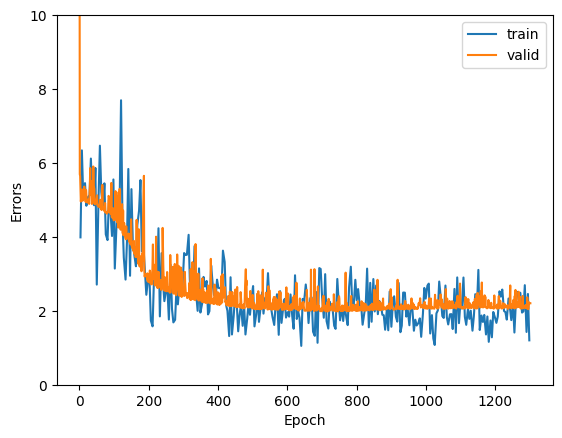

In [12]:
#plot 
import pandas as pd

loss_pack = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")
loss_valid=loss_pack.valloss.dropna()
loss_train=loss_pack.train_loss.dropna()


fig, ax = plt.subplots()
plt.plot(loss_train,label='train')
plt.plot(loss_valid,label='valid')
ax.axis(ymin=0,ymax=10)
#ax.semilogy(loss_train,'--',loss_valid,'.')
ax.set_xlabel("Epoch")
ax.set_ylabel("Errors")
plt.legend()
# Show the predicted surface, and compare to the reference one

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_net = 1, n1 = 10):  #n1 is the number of neurons for the first layer
        super().__init__()
        subnet = nn.Sequential(
            nn.Linear(3, n1),
            nn.Tanh(),
            nn.Linear(n1, n1),
            nn.Tanh(),
            nn.Linear(n1, 1)
        )
        subnets = [subnet for i in range(Num_element)] 
        self.model = nn.ModuleList(subnets)

    def forward(self, x):
        b_size, n_atom = x.shape
        atomic_E = torch.zeros((b_size, n_atom//3)).to(device)
        for i_atom in range(Num_atom):
            i_subnet = type_list[i_atom]
            atomic_E[:,i_atom] = torch.flatten(self.model[i_subnet](x[:,3*i_atom:3*(i_atom+1)]))
        Eout  = torch.sum(atomic_E, axis = 1)
        return Eout

def train_loop(dataloader, model, lossfn, optimizer, i_epoch):
    size = len(dataloader.dataset)
    for batch, (input_feature, target) in enumerate(dataloader):
        pred = model(input_feature)   # call model.forward()
        loss = lossfn(pred.squeeze(), target)
    
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch+1 == ceil(len(train_loader.dataset)/DLparams['batch_size']) and i_epoch % 100 == 0:
            loss, current = loss.item(), batch * len(input_feature)
            print(f"epoch: {i_epoch:>3d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]")

In [13]:
# Training of Machine Learning Model
learning_rate = 1e-4
num_epochs = 2000
n_net = Num_element
n1 = 10 
model = NeuralNetwork(n_net, n1).to(device)
lossfn = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

for i_epoch in range(num_epochs):
    train_loop(train_loader, model, lossfn, optimizer, i_epoch)
print("Done with Training!")

epoch:   0 loss: 252.735  [  560/  600]
epoch: 100 loss:   5.611  [  560/  600]
epoch: 200 loss:   3.863  [  560/  600]
epoch: 300 loss:   5.488  [  560/  600]
epoch: 400 loss:   3.515  [  560/  600]
epoch: 500 loss:   4.633  [  560/  600]
epoch: 600 loss:   5.382  [  560/  600]
epoch: 700 loss:   4.251  [  560/  600]
epoch: 800 loss:   4.070  [  560/  600]
epoch: 900 loss:   6.003  [  560/  600]
epoch: 1000 loss:   5.612  [  560/  600]
epoch: 1100 loss:   4.939  [  560/  600]
epoch: 1200 loss:   3.618  [  560/  600]
epoch: 1300 loss:   5.979  [  560/  600]
epoch: 1400 loss:   5.649  [  560/  600]
epoch: 1500 loss:   4.421  [  560/  600]
epoch: 1600 loss:   4.676  [  560/  600]
epoch: 1700 loss:   3.891  [  560/  600]
epoch: 1800 loss:   3.284  [  560/  600]
epoch: 1900 loss:   6.341  [  560/  600]
Done with Training!
